In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

In [9]:
pd.set_option('display.max_columns', None)
# load the data
data = pd.read_csv('../data/merged_data.csv')

data

,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,rsa_week_9,rsa_week_10,rsa_week_11,rsa_week_12,rsa_week_13,rsa_week_14,rsa_week_15,rsa_week_16,rsa_week_17,rsa_week_18,rsa_week_19,rsa_week_20,rsa_week_21,rsa_week_22,rsa_week_23,rsa_week_24,dropout,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,meds_methadone_5,meds_buprenorphine_5,meds_methadone_6,meds_buprenorphine_6,meds_methadone_7,meds_buprenorphine_7,meds_methadone_8,meds_buprenorphine_8,meds_methadone_9,meds_buprenorphine_9,meds_methadone_10,meds_buprenorphine_10,meds_methadone_11,meds_buprenorphine_11,meds_methadone_12,meds_buprenorphine_12,meds_methadone_13,meds_buprenorphine_13,meds_methadone_14,meds_buprenorphine_14,meds_methadone_15,meds_buprenorphine_15,meds_methadone_16,meds_buprenorphine_16,meds_methadone_17,meds_buprenorphine_17,meds_methadone_18,meds_buprenorphine_18,meds_methadone_19,meds_buprenorphine_19,meds_methadone_20,meds_buprenorphine_20,meds_methadone_21,meds_buprenorphine_21,meds_methadone_22,meds_buprenorphine_22,meds_methadone_23,meds_buprenorphine_23,meds_methadone_24,meds_buprenorphine_24,test_Propoxyphene_0,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_MMethadone_0,test_Oxycodone_0,test_Cocaine_0,test_Methamphetamine_0,test_Opiate300_0,test_Propoxyphene_1,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_MMethadone_1,test_Oxycodone_1,test_Cocaine_1,test_Methamphetamine_1,test_Opiate300_1,test_Propoxyphene_2,test_Amphetamines_2,test_Cannabinoids_2,test_Benzodiazepines_2,test_MMethadone_2,test_Oxycodone_2,test_Cocaine_2,test_Methamphetamine_2,test_Opiate300_2,test_Propoxyphene_3,test_Amphetamines_3,test_Cannabinoids_3,test_Benzodiazepines_3,test_MMethadone_3,test_Oxycodone_3,test_Cocaine_3,test_Methamphetamine_3,test_Opiate300_3,test_Propoxyphene_4,test_Amphetamines_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_MMethadone_4,test_Oxycodone_4,test_Cocaine_4,test_Methamphetamine_4,test_Opiate300_4,test_Propoxyphene_5,test_Amphetamines_5,test_Cannabinoids_5,test_Benzodiazepines_5,test_MMethadone_5,test_Oxycodone_5,test_Cocaine_5,test_Methamphetamine_5,test_Opiate300_5,test_Propoxyphene_6,test_Amphetamines_6,test_Cannabinoids_6,test_Benzodiazepines_6,test_MMethadone_6,test_Oxycodone_6,test_Cocaine_6,test_Methamphetamine_6,test_Opiate300_6,test_Propoxyphene_7,test_Amphetamines_7,test_Cannabinoids_7,test_Benzodiazepines_7,test_MMethadone_7,test_Oxycodone_7,test_Cocaine_7,test_Methamphetamine_7,test_Opiate300_7,test_Propoxyphene_8,test_Amphetamines_8,test_Cannabinoids_8,test_Benzodiazepines_8,test_MMethadone_8,test_Oxycodone_8,test_Cocaine_8,test_Methamphetamine_8,test_Opiate300_8,test_Propoxyphene_9,test_Amphetamines_9,test_Cannabinoids_9,test_Benzodiazepines_9,test_MMethadone_9,test_Oxycodone_9,test_Cocaine_9,test_Methamphetamine_9,test_Opiate300_9,test_Propoxyphene_10,test_Amphetamines_10,test_Cannabinoids_10,test_Benzodiazepines_10,test_MMethadone_10,test_Oxycodone_10,test_Cocaine_10,test_Methamphetamine_10,test_Opiate300_10,test_Propoxyphene_11,test_Amphetamines_11,test_Cannabinoids_11,test_Benzodiazepines_11,test_MMethadone_11,test_Oxycodone_11,test_Cocaine_11,test_Methamphetamine_11,test_Opiate300_11,test_Propoxyphene_12,test_Amphetamines_12,test_Cannabinoids_12,test_Benzodiazepines_12,test_MMethadone_12,test_Oxycodone_12,test_Cocaine_12,test_Methamphetamine_12,test_Opiate300_12,test_Propoxyphene_13,test_Amphetamines_13,test_Cannabinoids_13,test_Benzodiazepines_13,test_MMethadone_13,test_Oxycodone_13,test_Cocaine_13,test_Methamphetamine_13,test_Opiate300_13,test_Propoxyphene_14,test_Amphetamines_14,test_Cannabinoids_14,test_Benzodiazepines_14,test_MMethadone_14,test_Oxycodone_14,test_Cocaine_14,test_Methamphetamine_14,test_Opiate300_14,test_Propoxyphene_15,test_Amphetamines_15,test_Cannabinoids_15,test_Benzo

## Review Tests

In [10]:
tests = data[[col for col in data.columns if 'test_Opiate300' in col]].iloc[:, :5]
tests

,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1912,1.0,1.0,1.0,1.0,1.0
1913,1.0,0.0,0.0,0.0,0.0
1914,1.0,1.0,1.0,1.0,1.0
1915,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [11]:
survey = data[[col for col in data.columns if col.startswith('survey_')]].iloc[:, :20]
survey

,survey_cannabis_0,survey_cocaine_0,survey_alcohol_0,survey_oxycodone_0,survey_mmethadone_0,survey_amphetamine_0,survey_methamphetamine_0,survey_opiates_0,survey_benzodiazepines_0,survey_propoxyphene_0,survey_cannabis_4,survey_cocaine_4,survey_alcohol_4,survey_oxycodone_4,survey_mmethadone_4,survey_amphetamine_4,survey_methamphetamine_4,survey_opiates_4,survey_benzodiazepines_4,survey_propoxyphene_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,0.0,23.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,9.0,18.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
3,1.0,2.0,0.0,1.0,0.0,0.0,0.0,30.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1913,0.0,0.0,1.0,0.0,4.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Review Numeric

In [12]:
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

cows = data[[col for col in data.columns if 'cows' in col]]

num_df = pd.concat([rsa, meds, tests, survey, cows], axis=1)

num_df.shape

(1917, 42)

## Review Categorical

In [13]:
# demographic data
dem = data[[col for col in data.columns if col.startswith('dem_')]]

# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]

# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]

# create df for physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]

# concat cat features into cat_df
cat_df = pd.concat([dem, dsm, mdh, pex], axis=1)

# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, dtype=int)

cat_df.shape



(1917, 145)

In [ ]:
#tests = data[[col for col in data.columns if col.startswith('test_')]].iloc[:, :9]
#drug_names = [re.sub(r"^.*?_(.*?)_.*$", r"\1", s) for s in tests.columns]
#drug_names

## Assign Target Variable and Combine

In [14]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

new_data.shape


(1917, 188)

## Classification Workflow

In [15]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 187)
Shape of X_val: (192, 187)
Shape of X_test: (384, 187)


In [16]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=4, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'objective': 'binary:logistic', 'subsample': 0.3}
Highest ROC AUC found:  0.8943949759837557


In [17]:
# refit the model with the best params
best_params = grid_auc.best_params_
best_gbm = xgb.XGBClassifier(**best_params)
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

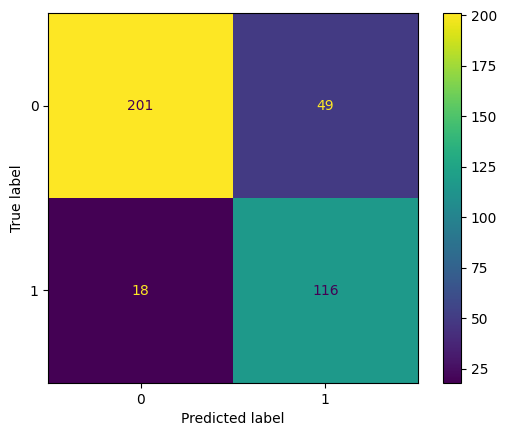

In [18]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

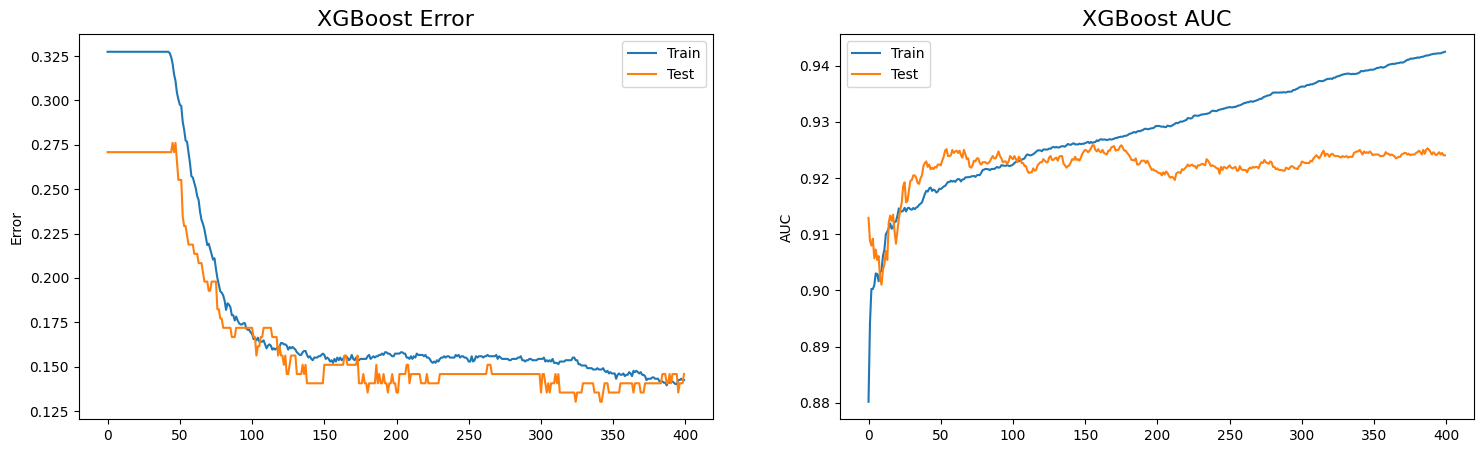

In [19]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [20]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8575689783743475
Validation Accuracy:  0.8541666666666666
Test Accuracy:  0.8255208333333334


In [21]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       902
         1.0       0.74      0.87      0.80       439

    accuracy                           0.86      1341
   macro avg       0.84      0.86      0.84      1341
weighted avg       0.87      0.86      0.86      1341



In [22]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86       250
         1.0       0.70      0.87      0.78       134

    accuracy                           0.83       384
   macro avg       0.81      0.83      0.82       384
weighted avg       0.84      0.83      0.83       384



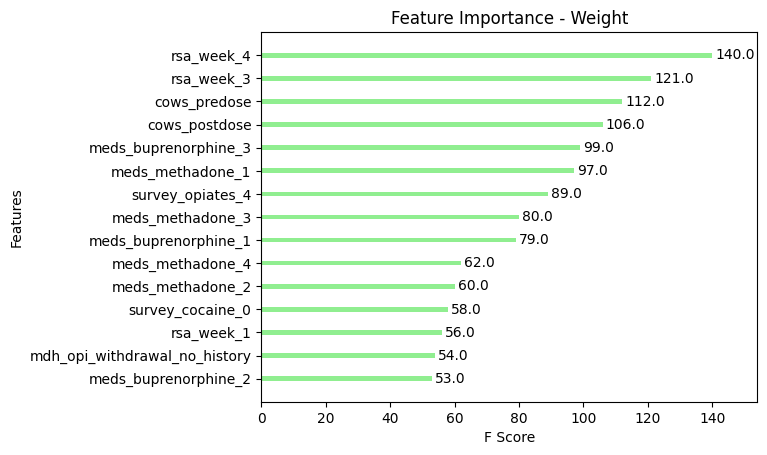

In [23]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=15, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

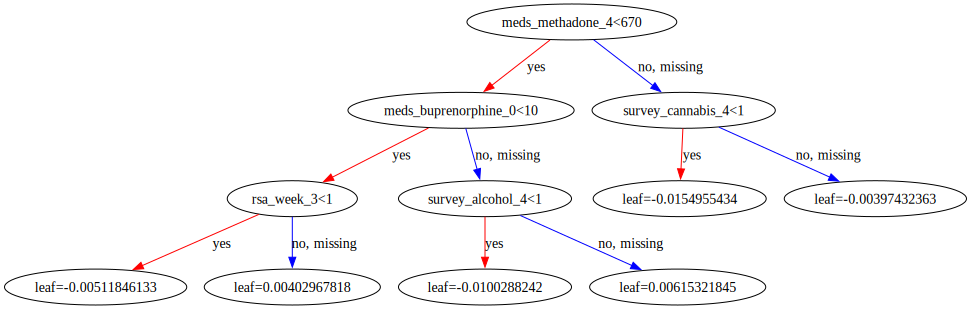

In [26]:
# Assuming 'xg_reg' is your trained XGBoost model
graph = xgb.to_graphviz(grid_auc.best_estimator_, num_trees=399)
# can I print the num trees argument?

# Display the tree plot directly in the notebook
graph